# Evaluating Home Field Advantage During the 2018 NFL, NHL, MLB, and NBA Regular Seasons

## Import packages and config

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import mysql.connector
import config
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.stats.power import TTestIndPower, TTestPower
from statsmodels.formula.api import ols
import statsmodels.api as sm

## Connect to database

In [2]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = 'sports'
)
cursor = cnx.cursor(buffered=True)

## Define Functions

In [52]:
# Creates the 'home_pt_diff' column
def home_pt_diff(df):
    df['home_pt_diff'] = df['home_team_score'] - df['away_team_score']
    return df['home_pt_diff']



# Returns a list of the actual data in the df. Suggestion: pass through only one column
def get_Actuals(df):
    actuals = [df.iloc[i] for i in range(df.shape[0])]
    return actuals



# Returns a list of z-scores of the actual data in df. Suggestion: pass through only one column
def get_Zscores(df):
    mu = df.mean()
    sigma = df.std()
    z_scores = [(df.iloc[i]-mu)/sigma for i in range(df.shape[0])]
    return z_scores



# Runs a one-sample t-test on data. Population_mean = mu and alpha = a.
# Pass a bool through 'two_tail' to run a two_tail or one_tail test (True = 2 tail, False = 1 tail)
def run_ttest(data, mu, alpha, two_tail):
    
    #calculate parameters
    n = len(data)
    s = np.std(data)
    x_bar = np.mean(data)
    std_err = s/np.sqrt(n)
    
    #calculate the t-value and p-value
    t = (x_bar-mu)/std_err
    p_values = stats.ttest_1samp(a=data, popmean=mu)
    p = p_values[1]

    #Where function becomes conditional based on two-tail test or one-tail test
    if two_tail:

        #calculate crotocal t-value
        t_crit = stats.t.ppf(1-alpha/2, df=n-1)

        #print results of test
        if (t>t_crit) and (p<alpha):
            print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}\n')
        else:
            print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}\n')

    else:
        #calculate the critical t-value
        t_crit = stats.t.ppf(1-alpha, df=n-1)

        #print results of test
        if (t>t_crit) and (p<alpha):
            print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}\n')
        else:
            print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}\n')


        
# Creates a conditional column "timing". A 0 indicates early in the season and a 1 indicates late in the season
def time_of_season(df, timing_list):
    df['timing'] = 0
    for i in range(df.shape[0]):
        if df['month'].iloc[i] in timing_list:
            df['timing'].iloc[i] = 0
        else:
            df['timing'].iloc[i] = 1

            
            
# Creates a new dataframe based on home team winning and timing of the game in the season (early or late)
# Used in calculating conditional probabilities
def create_HTW_timing_df(df, timing):
    new_df = df[(df['home_pt_diff']>0) & (df['timing'] == timing)]
    return new_df
        
    
    
# Generates a new dataframe based soley on timing of the game (early or late)    
def create_timing_df(df, timing):
    new_df = df[df['timing'] == timing]
    return new_df



# Calculates Cohen's D. Suggestion: only pass lists in as data1 and data2
def Cohen_d(data1, data2):
    
    #calculate parameters
    xbar_1, xbar_2 = np.mean(data1), np.mean(data2)
    var_1, var_2 = np.var(data1), np.var(data2)
    n1, n2 = len(data1), len(data2)
    var_p = ((n1-1)*var_1 + (n2-1)*var_2) / (n1+n2-2)
    
    #calculate Cohen's D
    d = (xbar_1 - xbar_2) / np.sqrt(var_p)
    return d



# Runs a two-sample t-test on df_early, df_late, and alpha = a.
# Returns results of t-test, t-value, critical t-value, and p-value
# Pass a bool through 'two_tail' to run a two_tail or one_tail test (True = 2 tail, False = 1 tail)
def run_2ttest(data1, data2, alpha, two_tail):

    #calculate parameters
    xbar_1, xbar_2 = np.mean(data1), np.mean(data2)
    var_1, var_2 = np.var(data1), np.var(data2)
    n1, n2 = len(data1), len(data2)
    var_p = ((n1-1)*var_1 + (n2-1)*var_2) / (n1+n2-2)
    ddof = (n1+n2-2)
    
    #calculate t-value
    t = abs(xbar_1 - xbar_2) / np.sqrt(var_p*((1/n1) + (1/n2)))
    

    #Where function becomes conditional based on two-tail test or one-tail test
    if two_tail:
        
        #calculate critical t-value and p-value
        t_crit = stats.t.ppf(1-(alpha/2),df=ddof)
        lower_tail = stats.t.cdf(-t, ddof, 0, 1)
        upper_tail = 1-stats.t.cdf(t, ddof, 0, 1)
        p = lower_tail + upper_tail

        #calculate power
        effect_size = Cohen_d(data1, data2)
        power_analysis = TTestIndPower()
        power = power_analysis.solve_power(effect_size=effect_size, nobs1=(n1+n2)//2, alpha=alpha)

        #print results of test
        if (t>t_crit) and (p<alpha):
            print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}')
            print(f' Effect Size: {effect_size}')
        else:
            print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}')
            print(f' Effect Size: {effect_size}')    
        print(f'  Sample mean difference is {round((xbar_1-xbar_2),3)}\n')
    
    else:
        #calculate critical t-value and p-value
        t_crit = stats.t.ppf(1-(alpha),df=ddof)
        upper_tail = 1-stats.t.cdf(t, ddof, 0, 1)
        p = upper_tail

        #calculate power
        effect_size = Cohen_d(data1, data2)
        power_analysis = TTestIndPower()
        power = power_analysis.solve_power(effect_size=effect_size, nobs1=(n1+n2)//2, alpha=alpha)

        #print results of test
        if (t>t_crit) and (p<alpha):
            print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}')
            print(f' Effect Size: {effect_size}')
        else:
            print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}')
            print(f' Effect Size: {effect_size}')    
        print(f'  Sample mean difference is {round((xbar_1-xbar_2),3)}\n')

## Data Gathering / Processing

Query MySQL to gather data for questions 1 and 2. Create dataframes using pandas for anaylsis

In [4]:
#football
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.nfl
;
""")

nfl_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nfl_df = pd.DataFrame(nfl_data,columns=columns).set_index('game_id')


nfl_df['home_pt_diff'] = 0 # create dummy values for a new column
nfl_df['home_pt_diff'] = nfl_df.apply(home_pt_diff, axis=1) #apply the home_pt_function to the new column

#hockey
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.nhl
;
""")

nhl_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nhl_df = pd.DataFrame(nhl_data,columns=columns).set_index('game_id')
nhl_df['home_pt_diff'] = 0
nhl_df['home_pt_diff'] = nhl_df.apply(home_pt_diff, axis=1)

#baseball
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.mlb
;
""")

mlb_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

mlb_df = pd.DataFrame(mlb_data,columns=columns).set_index('game_id')
mlb_df['home_pt_diff'] = 0
mlb_df['home_pt_diff'] = mlb_df.apply(home_pt_diff, axis=1)

#basketball
cursor.execute("""
SELECT
    *
FROM
    sports.nba
WHERE
    (month > 10 and month <= 12) OR (month >= 01 and month < 04)
;
""")

nba_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nba_df = pd.DataFrame(nba_data,columns=columns).set_index('game_id')
nba_df['home_pt_diff'] = 0
nba_df['home_pt_diff'] = nba_df.apply(home_pt_diff, axis=1)

Examine dataframes

In [5]:
nfl_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff
game_id,,,,,,
201810101,09,WAS,38,ARI,15,-23
201810103,09,BUF,7,BAL,74,67
201810105,09,DAL,13,CAR,25,12
201810108,09,PIT,33,CLE,33,0
201810110,09,SEA,38,DEN,43,5


In [6]:
nhl_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff
game_id,,,,,,
13093,10,PHI,9,OTT,5,-4
13094,10,VEG,3,WAS,7,4
13095,10,ARI,4,ANA,3,-1
13096,10,MON,3,TOR,4,1
13097,10,BOS,0,WAS,9,9


In [7]:
mlb_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff
game_id,,,,,,
54052,03,SEA,14,OAK,11,-3
54066,03,SEA,13,OAK,10,-3
54152,03,CHW,8,KC,13,5
54153,03,CHC,19,TEX,10,-9
54154,03,HOU,13,TB,3,-10


In [8]:
nba_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff
game_id,,,,,,
4491,11,IND,107,NYK,101,-6
4492,11,DEN,108,CHI,107,-1
4493,11,UTA,125,MIN,128,3
4494,11,NOP,121,GSW,131,10
4495,11,DAL,113,LAL,114,1


Generate a list of actual and standarized home team point differential data. Uses formulas defined above.

In [9]:
#football
nfl_actuals = get_Actuals(nfl_df['home_pt_diff'])
nfl_zscores = get_Zscores(nfl_df['home_pt_diff'])

#hockey
nhl_actuals = get_Actuals(nhl_df['home_pt_diff'])
nhl_zscores = get_Zscores(nhl_df['home_pt_diff'])

#baseball
mlb_actuals = get_Actuals(mlb_df['home_pt_diff'])
mlb_zscores = get_Zscores(mlb_df['home_pt_diff'])

#basketball
nba_actuals = get_Actuals(nba_df['home_pt_diff'])
nba_zscores = get_Zscores(nba_df['home_pt_diff'])

## Question 1: Is there home field advantage in any of the four major sports? To answer this question, we performed 4 separate one-sample one-sided t-tests testing the following alternative hypothesis:

$H_0:$ The average home point differential is not signficantly different than 0

$H_1:$ The average home point differential is significantly greater than 0, implying "home field advantage"

#### Steps performed:

Using the dataframes created above, create a list of dictionaries for the sports data. We will iterate through this list to create our x_data and y_data for the below chart

In [10]:
sports_dict = [
    {'sample' : 'Football',
     'data' : nfl_actuals
    },
    {'sample' : 'Hockey',
     'data' : nhl_actuals
    },
    {'sample' : 'Baseball',
     'data' : mlb_actuals
    },
    {'sample' : 'Basketball',
     'data' : nba_actuals
    }
]

#create a list of x values and y values for boxplot
boxplot_x = []
boxplot_y = []
for sport in sports_dict:
    for i in range(len(sport['data'])):
        boxplot_x.append(sport['sample'])
        boxplot_y.append(sport['data'][i])

Create a boxplot, x-axis split by sport, of the data we queried. This allows us to visualize the data we gathered.

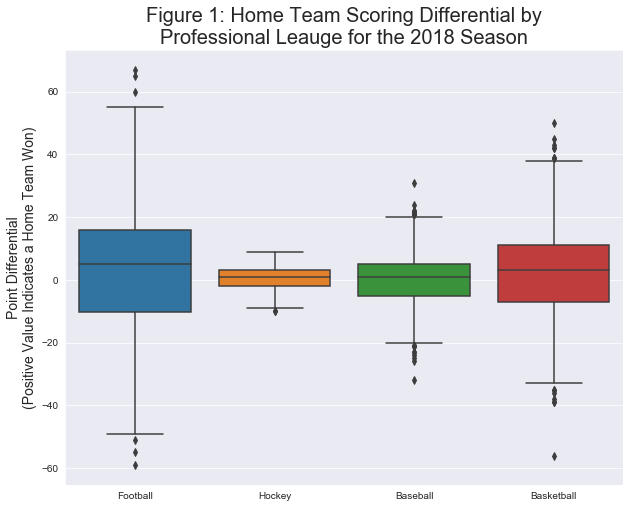

In [11]:
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(111)
sns.boxplot(x=boxplot_x, y=boxplot_y, ax=ax1);
ax1.set_title('Figure 1: Home Team Scoring Differential by\nProfessional Leauge for the 2018 Season', {'fontsize' : 20});
ax1.set_ylabel('Point Differential\n(Positive Value Indicates a Home Team Won)', {'fontsize' : 14});

Run t-tests to test whether or not these positive sample means are significantly greater than 0

In [53]:
#football
print('NFL:')
run_ttest(nfl_actuals, 0, 0.05, two_tail=False)

#football
print('NHL:')
run_ttest(nhl_actuals, 0, 0.05, two_tail=False)

#football
print('MLB:')
run_ttest(mlb_actuals, 0, 0.05, two_tail=False)

#football
print('NBA:')
run_ttest(nba_actuals, 0, 0.05, two_tail=False)

NFL:
Null hypothesis rejected. Results are statistically significant since t-value: 2.524 > critical t-value: 1.651 and p-value: 0.012378282339276653 < alpha: 0.05

NHL:
Null hypothesis rejected. Results are statistically significant since t-value: 4.22 > critical t-value: 1.646 and p-value: 2.637527049534951e-05 < alpha: 0.05

MLB:
Null hypothesis not rejected. Results are not statistically significant with t-value: 1.102 < critical t-value: 1.645 and p-value: 0.27075858563627736 > alpha: 0.05

NBA:
Null hypothesis rejected. Results are statistically significant since t-value: 5.825 > critical t-value: 1.646 and p-value: 7.432557876116745e-09 < alpha: 0.05



## The Results

Fig. 1 suggests that the average home team point differential is positive, indicating the potential for "home field advantage"

Our t-tests indicate that for 3 of the 4 major professional sports (Football, Hockey, and Basketball), the average home team point differential is significantly greater than 0, and thus there is statistical evidence to suggest "home field advantage" exists in these sports. However, there exists no statistical evidence to suggest that the average home team point differential is significantly greater than 0 in baseball (this suggests we cannot definitively say that "home field advantage" exists in baseball).

## Question 2: Is there an advantage to playing at home earlier in the season as compared to later in the season? To answer this question, we performed 4 separate two-sample two-sided t-tests testing the following alternative hypothesis:

$H_0:$ There is no significant difference between the average home point differential of late season games and the average home point differential of early season games

$H_1:$ The average home point differential of late season games is significantly different than the average home point differential of early season games

#### Steps performed:

Generate timing list of "early season months". If month is not in list, month is considered a "late season month"

In [13]:
#football
nfl_timing = ['09','10']

#hockey
nhl_timing = ['10', '11', '12']

#baseball
mlb_timing = ['03','04','05']

#basketball
nba_timing = ['11','12']

Expand dataframe to include conditional column "timing" where 1 = late in the season and 0 = early in the season. Uses formula defined above

In [14]:
#football
time_of_season(nfl_df, nfl_timing)

#hockey
time_of_season(nhl_df, nhl_timing)

#baseball
time_of_season(mlb_df, mlb_timing)

#basketball
time_of_season(nba_df, nba_timing)

/Users/JacquesPierre/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
nfl_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
201810101,09,WAS,38,ARI,15,-23,0
201810103,09,BUF,7,BAL,74,67,0
201810105,09,DAL,13,CAR,25,12,0
201810108,09,PIT,33,CLE,33,0,0
201810110,09,SEA,38,DEN,43,5,0


In [16]:
nhl_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
13093,10,PHI,9,OTT,5,-4,0
13094,10,VEG,3,WAS,7,4,0
13095,10,ARI,4,ANA,3,-1,0
13096,10,MON,3,TOR,4,1,0
13097,10,BOS,0,WAS,9,9,0


In [17]:
mlb_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
54052,03,SEA,14,OAK,11,-3,0
54066,03,SEA,13,OAK,10,-3,0
54152,03,CHW,8,KC,13,5,0
54153,03,CHC,19,TEX,10,-9,0
54154,03,HOU,13,TB,3,-10,0


In [18]:
nba_df.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
4491,11,IND,107,NYK,101,-6,0
4492,11,DEN,108,CHI,107,-1,0
4493,11,UTA,125,MIN,128,3,0
4494,11,NOP,121,GSW,131,10,0
4495,11,DAL,113,LAL,114,1,0


Create two new dataframes to separate the games by timing (early timing = 0 or late timing = 1). Uses formula defined above

In [19]:
#football
nfl_df_early = create_timing_df(nfl_df, 0)
nfl_df_late = create_timing_df(nfl_df, 1)

#hockey
nhl_df_early = create_timing_df(nhl_df, 0)
nhl_df_late = create_timing_df(nhl_df, 1)

#baseball
mlb_df_early = create_timing_df(mlb_df, 0)
mlb_df_late = create_timing_df(mlb_df, 1)

#basketball
nba_df_early = create_timing_df(nba_df, 0)
nba_df_late = create_timing_df(nba_df, 1)

In [20]:
nfl_df_early.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
201810101,09,WAS,38,ARI,15,-23,0
201810103,09,BUF,7,BAL,74,67,0
201810105,09,DAL,13,CAR,25,12,0
201810108,09,PIT,33,CLE,33,0,0
201810110,09,SEA,38,DEN,43,5,0


In [21]:
nfl_df_late.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
201810903,11,PIT,36,BAL,25,-11,1
201810904,11,CHI,65,BUF,14,-51,1
201810905,11,TB,44,CAR,66,22,1
201810908,11,KC,58,CLE,33,-25,1
201810909,11,TEN,44,DAL,22,-22,1


Get a list of "early" and "late" home team point differentials. Uses formula defined above

In [22]:
#football
nfl_df_late_actuals = get_Actuals(nfl_df_late['home_pt_diff'])
nfl_df_early_actuals = get_Actuals(nfl_df_early['home_pt_diff'])

#hockey
nhl_df_late_actuals = get_Actuals(nhl_df_late['home_pt_diff'])
nhl_df_early_actuals = get_Actuals(nhl_df_early['home_pt_diff'])

#baseball
mlb_df_late_actuals = get_Actuals(mlb_df_late['home_pt_diff'])
mlb_df_early_actuals = get_Actuals(mlb_df_early['home_pt_diff'])

#basketball
nba_df_late_actuals = get_Actuals(nba_df_late['home_pt_diff'])
nba_df_early_actuals = get_Actuals(nba_df_early['home_pt_diff'])

Run t-tests to test the alternative hypothesis that the average home point differential of late season games is significantly different than the average home point differential of early season games

In [23]:
#football
print("NFL:")
run_2ttest(nfl_df_late_actuals, nfl_df_early_actuals, 0.05, two_tail=True)

#hockey
print("NHL:")
run_2ttest(nhl_df_late_actuals, nhl_df_early_actuals, 0.05, two_tail=True)

#baseball
print("MLB:")
run_2ttest(mlb_df_late_actuals, mlb_df_early_actuals, 0.05, two_tail=True)

#basketball
print("NBA:")
run_2ttest(nba_df_late_actuals, nba_df_early_actuals, 0.05, two_tail=True)

NFL:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.013 < critical t-value: 1.969 and p-value: 0.9898310731445188 > alpha: 0.05
 Effect Size: 0.001597109733922208
  Sample mean difference is 0.036

NHL:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.269 < critical t-value: 1.962 and p-value: 0.7876555124137834 > alpha: 0.05
 Effect Size: -0.015125129642124929
  Sample mean difference is -0.052

MLB:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.222 < critical t-value: 1.961 and p-value: 0.8243216849648041 > alpha: 0.05
 Effect Size: 0.00934200789669676
  Sample mean difference is 0.068

NBA:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.923 < critical t-value: 1.962 and p-value: 0.35640823131743465 > alpha: 0.05
 Effect Size: -0.05514891478304814
  Sample mean difference is -0.784



#### Additional analysis - calculated conditional probabilities. Example "what is the probability of winning at home given the game is played late (or early) in the season"

Create two new dataframes to separate the games where the home team point differential was positive (indicating the home team won) and timing was "early" or "late" (timing = 0 or 1). Uses formula defined above

In [24]:
#football
nfl_df_HTW_early = create_HTW_timing_df(nfl_df, 0)
nfl_df_HTW_late = create_HTW_timing_df(nfl_df, 1)

#Hockey
nhl_df_HTW_early = create_HTW_timing_df(nhl_df, 0)
nhl_df_HTW_late = create_HTW_timing_df(nhl_df, 1)

#Baseball
mlb_df_HTW_early = create_HTW_timing_df(mlb_df, 0)
mlb_df_HTW_late = create_HTW_timing_df(mlb_df, 1)

#Basketball
nba_df_HTW_early = create_HTW_timing_df(nba_df, 0)
nba_df_HTW_late = create_HTW_timing_df(nba_df, 1)

In [25]:
nfl_df_HTW_early.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
201810103,09,BUF,7,BAL,74,67,0
201810105,09,DAL,13,CAR,25,12,0
201810110,09,SEA,38,DEN,43,5,0
201810112,09,CHI,36,GB,38,2,0
201810119,09,TEN,32,MIA,43,11,0


In [26]:
nfl_df_HTW_late.head()

,month,away_team,away_team_score,home_team,home_team_score,home_pt_diff,timing
game_id,,,,,,,
201810905,11,TB,44,CAR,66,22,1
201810919,11,NYJ,15,MIA,21,6,1
201810920,11,DET,14,MIN,38,24,1
201810921,11,GB,27,NE,49,22,1
201810922,11,LAR,55,NO,71,16,1


Calculate conditional probabilities

In [27]:
#football
nfl_prob_HTW_given_E = nfl_df_HTW_early.shape[0]/nfl_df_early.shape[0]
nfl_prob_HTW_given_L = nfl_df_HTW_late.shape[0]/nfl_df_late.shape[0]
print(f"NFL:")
print(f" Probability of winning at home early in the season: {round(nfl_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nfl_prob_HTW_given_L*100,2)}%\n")

#hockey
nhl_prob_HTW_given_E = nhl_df_HTW_early.shape[0]/nhl_df_early.shape[0]
nhl_prob_HTW_given_L = nhl_df_HTW_late.shape[0]/nhl_df_late.shape[0]
print(f"NHL:")
print(f" Probability of winning at home early in the season: {round(nhl_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nhl_prob_HTW_given_L*100,2)}%\n")

#baseball
mlb_prob_HTW_given_E = mlb_df_HTW_early.shape[0]/mlb_df_early.shape[0]
mlb_prob_HTW_given_L = mlb_df_HTW_late.shape[0]/mlb_df_late.shape[0]
print(f"MLB:")
print(f" Probability of winning at home early in the season: {round(mlb_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(mlb_prob_HTW_given_L*100,2)}%\n")

#basketball
nba_prob_HTW_given_E = nba_df_HTW_early.shape[0]/nba_df_early.shape[0]
nba_prob_HTW_given_L = nba_df_HTW_late.shape[0]/nba_df_late.shape[0]
print(f"NBA:")
print(f" Probability of winning at home early in the season: {round(nba_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nba_prob_HTW_given_L*100,2)}%\n")

NFL:
 Probability of winning at home early in the season: 61.16%
 Probability of winning at home late in the season: 59.26%

NHL:
 Probability of winning at home early in the season: 53.68%
 Probability of winning at home late in the season: 53.64%

MLB:
 Probability of winning at home early in the season: 50.74%
 Probability of winning at home late in the season: 51.41%

NBA:
 Probability of winning at home early in the season: 60.36%
 Probability of winning at home late in the season: 56.09%



Generate a visualiztion of our conditional probibilities

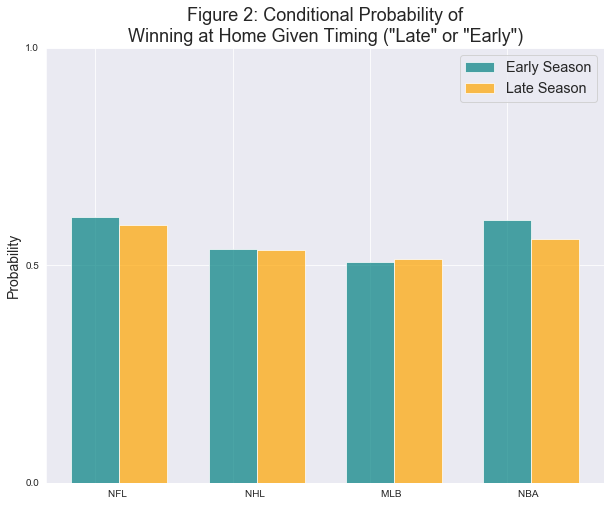

In [28]:
x_data = np.array([1,2,3,4])
y1_data = [nfl_prob_HTW_given_E, nhl_prob_HTW_given_E, mlb_prob_HTW_given_E, nba_prob_HTW_given_E,]
y2_data = [nfl_prob_HTW_given_L, nhl_prob_HTW_given_L, mlb_prob_HTW_given_L, nba_prob_HTW_given_L,]
width = 0.35

fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(111)
ax2.bar(x_data, y1_data, color='teal', width=width, alpha=0.7, label='Early Season');
ax2.bar(x_data+width, y2_data, color='orange', width=width, alpha=0.7, label='Late Season');
ax2.set_ylabel('Probability', {'fontsize' : 14});
ax2.set_title('Figure 2: Conditional Probability of\nWinning at Home Given Timing ("Late" or "Early")', {'fontsize' : 18});
ax2.set_ylim(0,1)
ax2.set_yticks([0, 0.5, 1])
plt.legend(fontsize='x-large');
plt.xticks([1,2,3,4],['                NFL','                NHL','                MLB','                NBA']);

## The Results

Despite Fig. 2 suggesting that a team is more likely to win at home earlier in the season, there exists no statistical evidence to support this theory.

## Question 3: In the NFL, do west coast teams cover the spread less frequently than east coast teams when traveling to the east coast? To answer this question, we ran a one-sample one-sided t-test on the following alternative hypothesis

$H_0:$ There is no statistical difference in the number of times the home team covers versus the away team

$H_1:$ On average, the home team covers more than 50% of the time

#### Steps include:

Query MySQL to get gambling data into dataframe

In [29]:
cursor.execute("""
SELECT
 *
FROM
    sports.nfl
;
""")

nfl = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'week',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
    'home_team_moneyline',
    'away_team_moneyline',
    'spread',
]

nfl_gambling = pd.DataFrame(nfl,columns=columns).set_index('game_id')
nfl_gambling.head()

,month,week,away_team,away_team_score,home_team,home_team_score,home_team_moneyline,away_team_moneyline,spread
game_id,,,,,,,,,
201810101,09,1,WAS,38,ARI,15,-161,-171,3.7
201810103,09,1,BUF,7,BAL,74,-163,-169,-11.8
201810105,09,1,DAL,13,CAR,25,172,-188,-4.0
201810108,09,1,PIT,33,CLE,33,166,-182,8.7
201810110,09,1,SEA,38,DEN,43,171,-186,-4.7


Create a list of teams on each located on the coastlines

In [30]:
west_coast = ['ARI', 'LAR', 'SF', 'SEA', 'LAC', 'OAK']
east_coast = ['NYG', 'PHI', 'WAS', 'TB', 'ATL', 'BUF', 'MIA', 'NE', 'NYJ', 'BAL', 'JAG', 'CAR']

Expand dataframe to include a conditional column where the home team is an east coast team and the away team is a west coast team

In [31]:
nfl_gambling['east_home_west_away'] = 0
for i in range(nfl_gambling.shape[0]):
    if nfl_gambling['away_team'].iloc[i] in west_coast and nfl_gambling['home_team'].iloc[i] in east_coast:
        nfl_gambling['east_home_west_away'].iloc[i] = 1
    else:
        nfl_gambling['east_home_west_away'].iloc[i] = np.nan

nfl_gambling.dropna(inplace=True)
nfl_gambling.head()

,month,week,away_team,away_team_score,home_team,home_team_score,home_team_moneyline,away_team_moneyline,spread,east_home_west_away
game_id,,,,,,,,,,
201810204,09,2,LAC,49,BUF,32,-182,166,11.8,1.0
201810319,09,3,OAK,32,MIA,44,161,-177,-4.0,1.0
201811203,11,12,OAK,27,BAL,54,-161,-171,-19.8,1.0
201811205,11,12,SEA,47,CAR,43,158,-174,-4.7,1.0
201811233,11,12,SF,14,TB,43,-166,-166,-3.2,1.0


Expand dataframe to include a conditional column where the home team is a "favorite," if the home team moneyline is negative

In [32]:
nfl_gambling['home_team_favorite'] = 0
for i in range(nfl_gambling.shape[0]):
    if nfl_gambling['home_team_moneyline'].iloc[i] < 0:
        nfl_gambling['home_team_favorite'].iloc[i] = 1
    else:
        nfl_gambling['home_team_favorite'].iloc[i] = 0
nfl_gambling.head()

,month,week,away_team,away_team_score,home_team,home_team_score,home_team_moneyline,away_team_moneyline,spread,east_home_west_away,home_team_favorite
game_id,,,,,,,,,,,
201810204,09,2,LAC,49,BUF,32,-182,166,11.8,1.0,1
201810319,09,3,OAK,32,MIA,44,161,-177,-4.0,1.0,0
201811203,11,12,OAK,27,BAL,54,-161,-171,-19.8,1.0,1
201811205,11,12,SEA,47,CAR,43,158,-174,-4.7,1.0,0
201811233,11,12,SF,14,TB,43,-166,-166,-3.2,1.0,1


Add the spread to the home team score if the home team is the favorite. Subtract the spread from the home team score if the home team is the underdog

In [33]:
nfl_gambling['adj_home_team_score'] = 0
for i in range(nfl_gambling.shape[0]):
    if nfl_gambling['home_team_favorite'].iloc[i] > 0:
        nfl_gambling['adj_home_team_score'].iloc[i] = int(nfl_gambling['home_team_score'].iloc[i] + (nfl_gambling['spread'].iloc[i]//1))
    else:
        nfl_gambling['adj_home_team_score'].iloc[i] = int(nfl_gambling['home_team_score'].iloc[i] - (nfl_gambling['spread'].iloc[i]//1))
nfl_gambling.head()

,month,week,away_team,away_team_score,home_team,home_team_score,home_team_moneyline,away_team_moneyline,spread,east_home_west_away,home_team_favorite,adj_home_team_score
game_id,,,,,,,,,,,,
201810204,09,2,LAC,49,BUF,32,-182,166,11.8,1.0,1,43
201810319,09,3,OAK,32,MIA,44,161,-177,-4.0,1.0,0,48
201811203,11,12,OAK,27,BAL,54,-161,-171,-19.8,1.0,1,34
201811205,11,12,SEA,47,CAR,43,158,-174,-4.7,1.0,0,48
201811233,11,12,SF,14,TB,43,-166,-166,-3.2,1.0,1,39


Expand the dataframe and calculate the adj. home team point differential. If home team covered, then 'home_team_covered' column equals 1

In [34]:
nfl_gambling['adj_home_pt_diff'] = 0
nfl_gambling['home_team_covered'] = 0
for i in range(nfl_gambling.shape[0]):
    nfl_gambling['adj_home_pt_diff'].iloc[i] = nfl_gambling['adj_home_team_score'].iloc[i] - nfl_gambling['away_team_score'].iloc[i]
    if nfl_gambling['adj_home_pt_diff'].iloc[i] > 0:
        nfl_gambling['home_team_covered'].iloc[i] = 1
    else:
        nfl_gambling['home_team_covered'].iloc[i] = 0
nfl_gambling.head()

,month,week,away_team,away_team_score,home_team,home_team_score,home_team_moneyline,away_team_moneyline,spread,east_home_west_away,home_team_favorite,adj_home_team_score,adj_home_pt_diff,home_team_covered
game_id,,,,,,,,,,,,,,
201810204,09,2,LAC,49,BUF,32,-182,166,11.8,1.0,1,43,-6,0
201810319,09,3,OAK,32,MIA,44,161,-177,-4.0,1.0,0,48,16,1
201811203,11,12,OAK,27,BAL,54,-161,-171,-19.8,1.0,1,34,7,1
201811205,11,12,SEA,47,CAR,43,158,-174,-4.7,1.0,0,48,1,1
201811233,11,12,SF,14,TB,43,-166,-166,-3.2,1.0,1,39,25,1


Generate a list of games where the home team covered = 1 and home team not covering = 0. Calculate probability home team covers

In [60]:
cover = get_Actuals(nfl_gambling['home_team_covered'])
print(cover)

prob_home_team_covers = len([i for i in cover if i == 1])/nfl_gambling.shape[0]
print(f"On average, the home team covers {round(prob_home_team_covers*100, 2)}% of the time")

[0, 1, 1, 1, 1, 1]
On average, the home team covers 83.33% of the time


Generate a visualiztion of our frequency data (home team covers = 1, home team does not cover = 0).

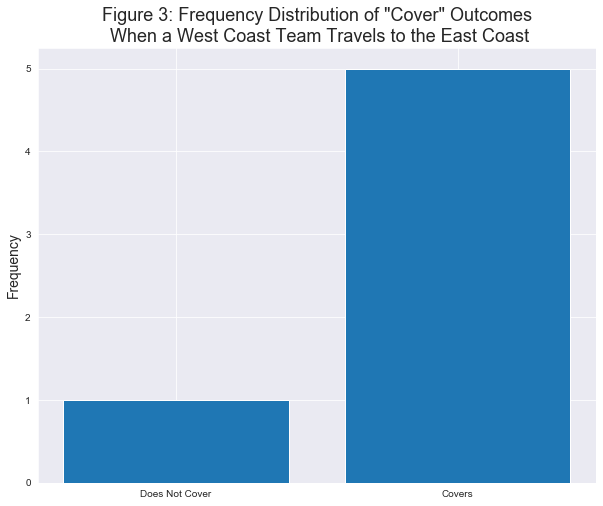

In [91]:
x_data = ['Does Not Cover', 'Covers']
y_data = [1, 5]

fig3 = plt.figure(figsize=(10,8))
ax3 = fig3.add_subplot(111);
ax3.bar(x_data, y_data);
ax3.set_title('Figure 3: Frequency Distribution of "Cover" Outcomes\n When a West Coast Team Travels to the East Coast', {'fontsize' : 18})
ax3.set_ylabel('Frequency', {'fontsize' : 14});

Run a the t-test to test the alternative hypothesis. Additionally, this will test whether or not on average the home team covers the spread more frequently than the away team.

In [95]:
run_ttest(cover, 0.50, 0.05, two_tail=False)

Null hypothesis not rejected. Results are not statistically significant with t-value: 2.191 < critical t-value: 2.015 and p-value: 0.10193947882985828 > alpha: 0.05



## The Results

Despite probability suggesting that the home team covers more frequently than the away team (when the home team is an east coast team and the wawy team is a west coast team), our limited sample size indicates that the exists no statistical evidence to suggest that the home team, on average, covers the spread more frequently than the away team.

# In Summary

In this project, we determined that there exists statistical evidence, in 3 of the 4 major sports (football, hockey, and basketball), of "home field advantage".

Additionally, we can conclude that there is no statistical evidence to suggest that the degree of "home field advantage" is different regardless of when the game is played in the season (early or late in the season).

Finaly, we can suggest that there is no statistical evidence, at least with our limited sample size, backing the theory that west coast teams, on average, do not cover the spread when traveling to the east coast; we would like to perform this test on a larger sample size as our sample size was only 6 games.  

# APPENDIX

#### Graph 4: A visualization of our data, which helped us form the 3 questions we wanted to ask.

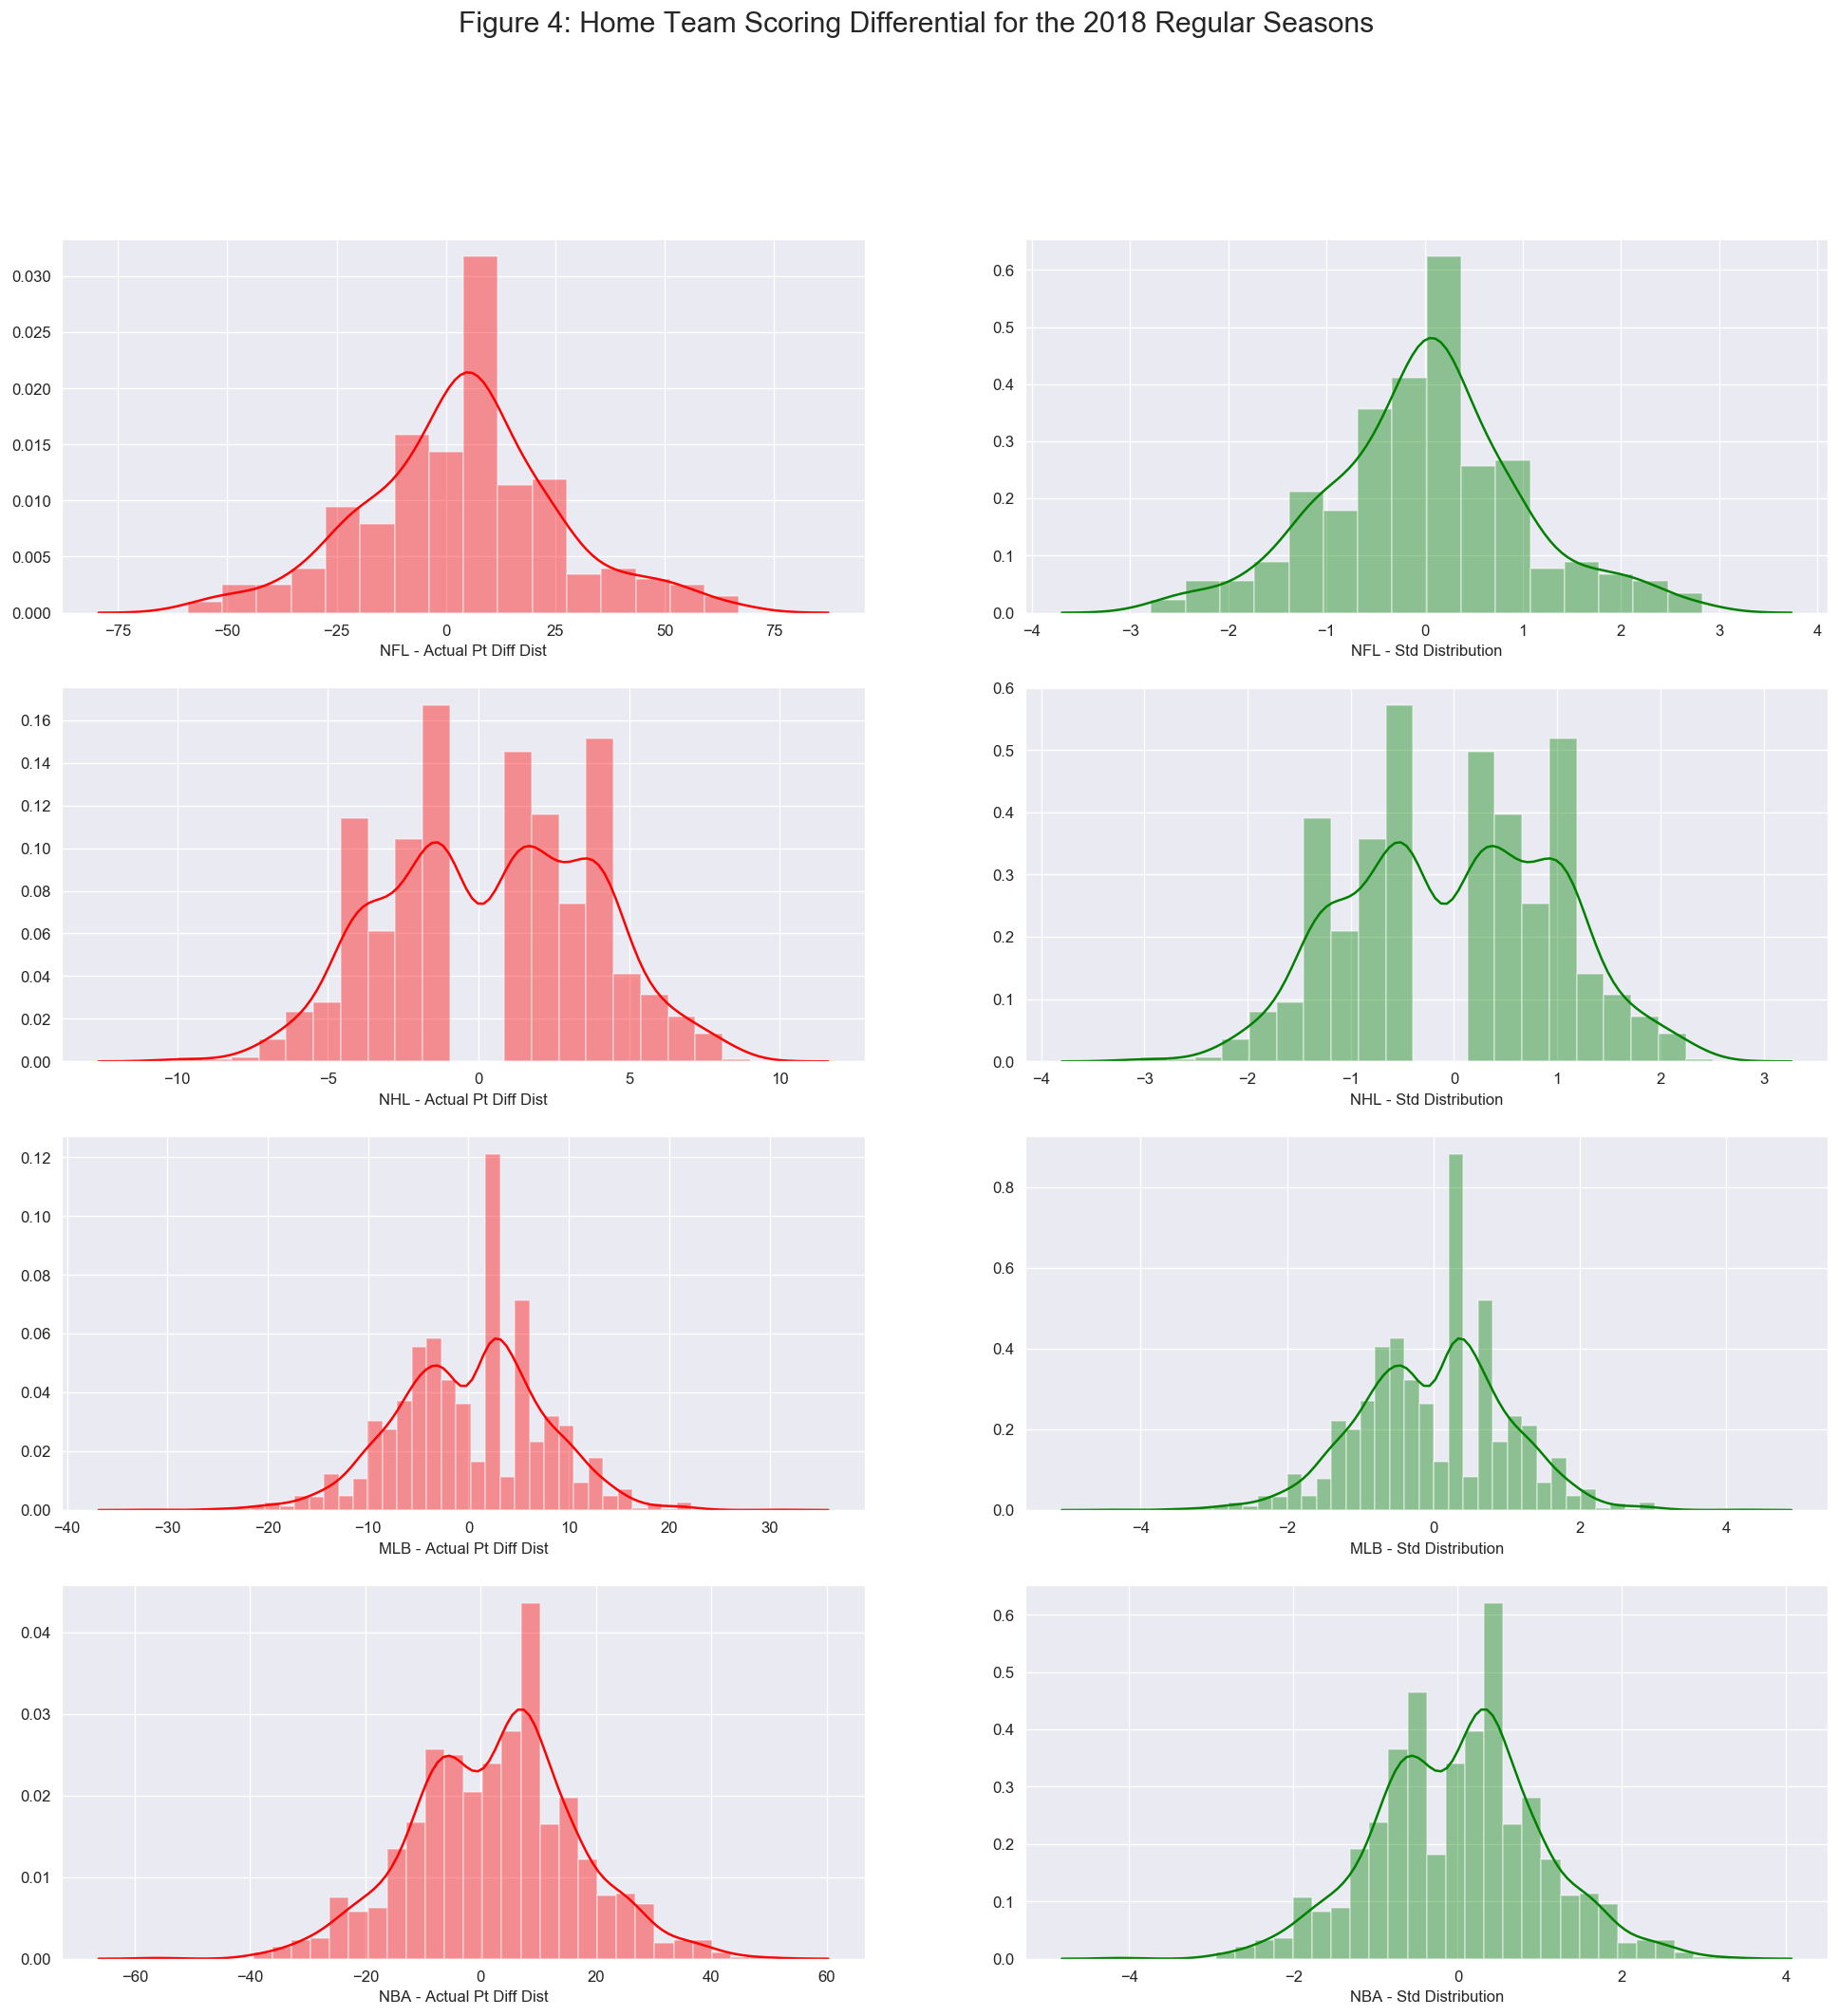

In [93]:
fig4, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20), sharex=False, sharey=False, dpi=120)
fig4.suptitle('Figure 4: Home Team Scoring Differential for the 2018 Regular Seasons', fontsize=18)

#football: actual / standard
sns.distplot(nfl_actuals,
             bins='auto',
             color='r',
             ax=axes[0][0],
             axlabel = 'NFL - Actual Pt Diff Dist'
            );

sns.distplot(nfl_zscores,
             bins='auto',
             color='g',
             ax=axes[0][1],
             axlabel = 'NFL - Std Distribution'
            );

#hockey: actual / standard
sns.distplot(nhl_actuals,
             bins='auto',
             color='r',
             ax=axes[1][0],
             axlabel = 'NHL - Actual Pt Diff Dist'
            );

sns.distplot(nhl_zscores,
             bins='auto',
             color='g',
             ax=axes[1][1],
             axlabel = 'NHL - Std Distribution'
            );

#baseball: actual / standard
sns.distplot(mlb_actuals,
             bins='auto',
             color='r',
             ax=axes[2][0],
             axlabel = 'MLB - Actual Pt Diff Dist'
            );

sns.distplot(mlb_zscores,
             bins='auto',
             color='g',
             ax=axes[2][1],
             axlabel = 'MLB - Std Distribution'
            );

#basketball: actual / standard
sns.distplot(nba_actuals,
             bins='auto',
             color='r',
             ax=axes[3][0],
             axlabel = 'NBA - Actual Pt Diff Dist'
            );

sns.distplot(nba_zscores,
             bins='auto',
             color='g',
             ax=axes[3][1],
             axlabel = 'NBA - Std Distribution'
            );

#### END - CLOSE CURSOR & CONNECTION

In [94]:
cursor.close()
cnx.close()